# Deep Learning Applications: Laboratory 1




### Install dependencies

`pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118`  
`pip install matplotlib`  
`pip install scikit-learn`  
`pip install tqdm`  
`pip install jupyterlab`  
`pip install ipython`  
`pip install wandb`  

## Exercise 1.1: A baseline MLP
In this exercise I implement a *simple* Multilayer Perceptron to classify the 10 digits of MNIST.
Then I evaluate the model in terms of loss and accuracy on validation and test set.
I use [Weights and Biases](https://wandb.ai/site) to monitor performance during the training process.

In [1]:
!pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.1/309.1 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.5 MB/s eta 0:00:00


#### Import Dependencies

In [2]:
# Start with some standard imports.
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import torch
import wandb
import math
import os
from torchvision.datasets import MNIST, CIFAR10
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
num_workers = 8

cpu


#### Define Training Pipeline and utility functions
These are the functions used for training and test processes.
After the training loop the best model (based on validation accuracy) is saved in `/trained_models` directory.

In [4]:
def train_epoch(model, dataloader, criterion, optimizer, epoch='Unknown', device='cpu', fully_conv=False):
    model.train()
    losses = []
    for (inputs, labels) in tqdm(dataloader, desc=f'Training epoch {epoch}', leave=True):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        if fully_conv:
            _, _, a, b = outputs.shape
            gts = labels.unsqueeze(-1).unsqueeze(-1).repeat(1,a,b)
            loss = criterion(outputs, gts)
        else:
            loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    avg_loss = np.mean(losses)
    return avg_loss


def evaluate_model(model, dataloader, criterion, device='cpu', fully_conv=False):
    model.eval()
    losses = []
    predictions = []
    gts = []
    with torch.no_grad():
        for (inputs, labels) in tqdm(dataloader, desc='Evaluating', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # 64x10x28x28
            if fully_conv:
                _, _, a, b = outputs.shape
                gt = labels.unsqueeze(-1).unsqueeze(-1).repeat(1,a,b)  # 64x28x28
                loss = criterion(outputs, gt)
            else:
                loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, dim=1)  # 64x28x28
            gts.append(gt.cpu().numpy())  # 93 64x28x28
            predictions.append(preds.detach().cpu().numpy())  # 93 64x28x28
            losses.append(loss.item())
    avg_loss = np.mean(losses)
    if fully_conv:
        gts = [x.flatten() for x in gts]
        predictions = [x.flatten() for x in predictions]
    accuracy = accuracy_score(np.hstack(gts), np.hstack(predictions))
    report = classification_report(np.hstack(gts), np.hstack(predictions), zero_division=0, digits=3)
    return avg_loss, accuracy, report


def plot_validation_curves(losses_and_accs, fig_path):
    train_losses = [x for (x, _, _) in losses_and_accs]
    val_losses = [x for (_, x, _) in losses_and_accs]
    accs = [x for (_, _, x) in losses_and_accs]
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(accs)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title(f'Best Accuracy = {round(np.max(accs), 2)} @ epoch {np.argmax(accs)}')
    plt.savefig(fig_path)

In [5]:
def train(model, train_set, criterion, optimizer, batch_size, epochs, model_name, fig_path, device='cpu', num_workers=0, fully_conv=False):
    # Init Weights and Biases
    wandb.init(project="dla_lab1")

    # Split train into train and validation.
    train_size = int(0.9 * len(train_set))
    val_size = len(train_set) - train_size
    train_set, val_set = random_split(train_set, [train_size, val_size])

    # Create data loaders.
    dl_train = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=num_workers)
    print("Training-Set Ready")
    dl_val = DataLoader(val_set, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=num_workers)
    print("Validation-Set Ready")

    wandb.watch(model, log="all")
    model.to(device)
    print("Starting Training...")
    losses_and_accs = []
    max_val_acc = 0
    min_val_loss = math.inf
    early_stop_counter = 0
    best_state_dict = None
    for epoch in range(epochs):
        # Train Epoch
        train_loss = train_epoch(model, dl_train, criterion, optimizer, epoch, device, fully_conv)
        # Evaluate Model
        val_loss, val_acc, _ = evaluate_model(model, dl_val, criterion, device, fully_conv)

        wandb.log({"train_loss": train_loss, "val_loss": val_loss, "val_accuracy": val_acc, "epoch": epoch})
        losses_and_accs.append((train_loss, val_loss, val_acc))

        # Pick best model
        if val_acc > max_val_acc:
            max_val_acc = val_acc
            best_state_dict = model.state_dict()

        #Early Stopping
        if val_loss < min_val_loss:
            min_val_loss = val_loss
            early_stop_counter = 0
        elif val_loss > (min_val_loss + 0.05):
            early_stop_counter += 1
        if early_stop_counter == 5:
            break

    wandb.unwatch()
    plot_validation_curves(losses_and_accs, fig_path)
    torch.save(best_state_dict, os.path.join('./trained_models/', model_name))

In [6]:
def test(model, test_set, criterion, model_name, device='cpu', num_workers=0, fully_conv=False):
    # Create data loader.
    test_dl = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=num_workers)

    # Load best model state dict
    print("Loading model...")
    model.load_state_dict(torch.load(os.path.join('./trained_models/', model_name)))
    model.to(device)
    print("Model Loaded")

    _, test_acc, classification_report = evaluate_model(model, test_dl, criterion, device, fully_conv)
    print(f'Test Accuracy: {test_acc}')
    print(classification_report)

#### A basic, parameterized MLP

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, input_channels, num_classes, dim=64):
        super().__init__()
        self.input_dim = input_dim
        self.input_channels = input_channels
        self.fc1 = nn.Linear(self.input_dim*self.input_dim*self.input_channels, dim*8)
        self.fc2 = nn.Linear(dim*8, dim*8)
        self.fc3 = nn.Linear(dim*8, dim*4)
        self.fc4 = nn.Linear(dim*4, dim)
        self.fc5 = nn.Linear(dim, num_classes)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        return x

#### Data preparation
In this section they are loaded train and test sets of MNIST data.

In [ ]:
# Standard MNIST transform.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST train and test.
train_set = MNIST(root='./data', train=True, download=True, transform=transform)
test_set = MNIST(root='./data', train=False, download=True, transform=transform)

#### Define Hyperparameters and Run Training
In this cell they are defined the hyperparameters for network architecture and for the training process.
They can be defined the model name (for saving) and the path for resulting plot.

In [ ]:
# Training hyperparameters.
epochs = 25
batch_size = 128
lr = 0.0001

# Instantiate model and optimizer
model_mlp = MLP(28, 1, 10)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_mlp.parameters(), lr=lr)

model_name = 'mlp_mnist.pth'
fig_path = 'results/mlp_mnist.png'

# Training loop
train(model_mlp, train_set, criterion, optimizer, batch_size, epochs, model_name, fig_path, device=device)

In [ ]:
test(model_mlp, test_set, criterion, 'mlp_mnist.pth', device=device)

NameError: name 'model_mlp' is not defined

## Exercise 1.2: Rinse and Repeat

Repeat the verification you did above, but with **Convolutional** Neural Networks. If you were careful about abstracting your model and training code, this should be a simple exercise. Show that **deeper** CNNs *without* residual connections do not always work better and **even deeper** ones *with* residual connections.

**Hint**: You probably should do this exercise using CIFAR10, since MNIST is *very* easy (at least up to about 99% accuracy).

**Spoiler**: If you plan to do optional exercise 2.3, you should think *very* carefully about the architectures of your CNNs here (so you can reuse them!).

#### CIFAR-10 Dataset

In [7]:
# These lines solve an SSL issue with the CIFAR10 dataset.
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Standard CIFAR10 transform.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

# Load CIFAR10 train and test.
train_set = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = CIFAR10(root='./data', train=False, download=True, transform=transform)

num_classes = 10
input_channels = 3

100%|██████████| 170498071/170498071 [00:17<00:00, 9863565.66it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Architecture
In this section I try to implement the original a simple CNN and a ResNet18 architecture, leaving a flag indicating the use or not use of skip connections, in order to quantify the differences in performance between the two architectural choices.

In [8]:
# A very simple CNN model.
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(64 * 6 * 6, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, skip_connection=True):
        super(ResidualBlock, self).__init__()
        self.skip_connection = skip_connection

        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        out = self.block(x)
        if self.skip_connection:
            out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, num_blocks, num_classes, channels=3, skip_connection=True):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.num_classes = num_classes
        self.skip_connection = skip_connection

        self.conv = nn.Sequential(
            nn.Conv2d(channels, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )

        self.layers = nn.Sequential(
            self._make_layer(ResidualBlock, 64, num_blocks[0], stride=1, skip_connection=skip_connection),
            self._make_layer(ResidualBlock, 128, num_blocks[1], stride=2, skip_connection=skip_connection),
            self._make_layer(ResidualBlock, 256, num_blocks[2], stride=2, skip_connection=skip_connection),
            self._make_layer(ResidualBlock, 512, num_blocks[3], stride=2, skip_connection=skip_connection),
        )

        self.pooling = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride, skip_connection=True):
        # [stride, 1, 1, ...] (num_blocks times) ensures that the first block has stride=stride
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride, skip_connection=skip_connection))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        """
        conv:    [batch_size, channels, 32, 32] -> [batch_size, 64, 32, 32]
        layer1:  [batch_size, 64, 32, 32] -> [batch_size, 64, 32, 32] (stride=1)
        layer2:  [batch_size, 64, 32, 32] -> [batch_size, 128, 16, 16] (stride=2)
        layer3:  [batch_size, 128, 16, 16] -> [batch_size, 256, 8, 8] (stride=2)
        layer4:  [batch_size, 256, 8, 8] -> [batch_size, 512, 4, 4] (stride=2)
        pooling: [batch_size, 512, 4, 4] -> [batch_size, 512, 1, 1] (avg_pool2d)
        resize:  [batch_size, 512, 1, 1] -> [batch_size, 512]
        fc:      [batch_size, 512] -> [batch_size, num_classes]
        """
        x = self.conv(x)
        x = self.layers(x)
        x = self.pooling(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

#### Define Hyperparameters and Run Training

epoch,▁▂▂▃▄▄▅▅▆▇▇█
train_loss,█▅▄▃▂▂▁▁▁▁▁▁
val_accuracy,▁▄▅▆▇▆██▇███
val_loss,█▄▃▁▂▃▁▃▃▃▄▃
epoch,11
train_loss,0.08037
val_accuracy,0.7682
val_loss,0.93573


Training-Set Ready
Validation-Set Ready
Starting Training...


Training epoch 18: 100%|██████████| 352/352 [00:07<00:00, 45.69it/s]


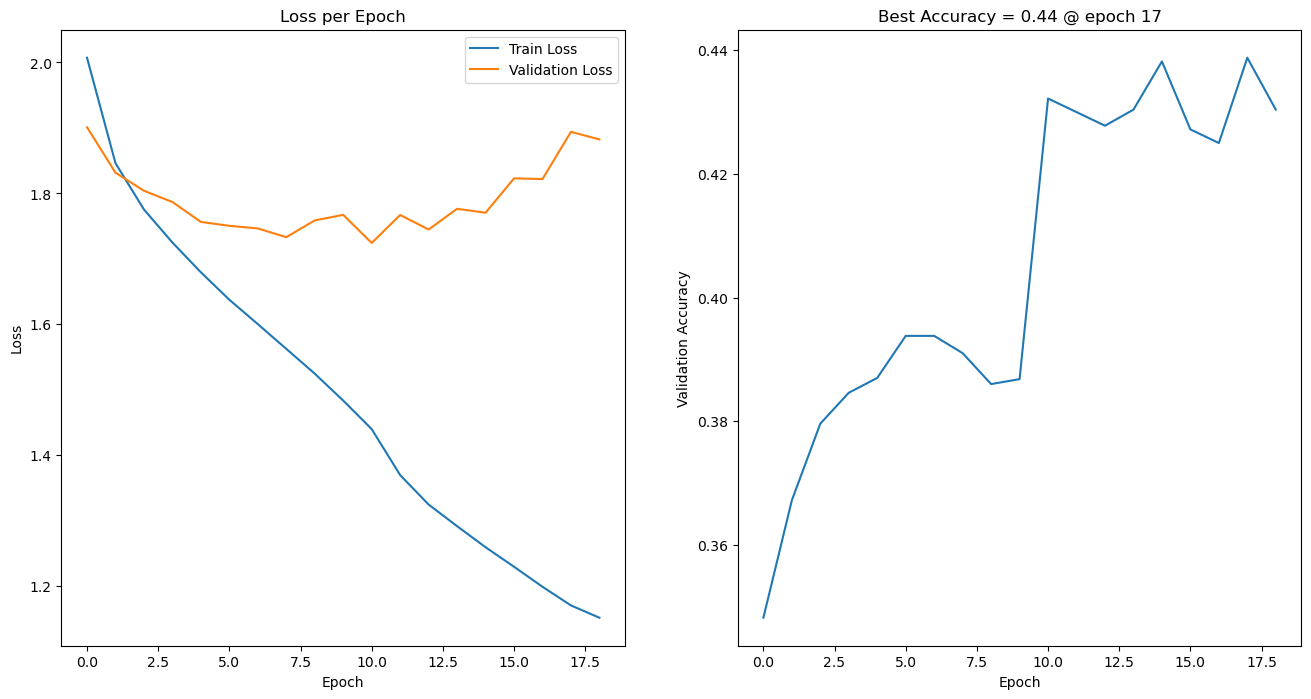

In [ ]:
# MLP
mlp = MLP(32, 3, 10)
optimizer_mlp = torch.optim.Adam(params=mlp.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()
# Training hyperparameters.
epochs = 50
batch_size = 128
lr = 0.0001

model_name = 'mlp_cifar.pth'
fig_path = 'results/mlp_cifar.png'

train(mlp, train_set, criterion, optimizer_mlp, batch_size, epochs, model_name, fig_path, device=device)

In [ ]:
# CNN
cnn = CNN()
optimizer_cnn = torch.optim.Adam(params=cnn.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

epochs = 50
batch_size = 128
lr = 0.0001

model_name = 'cnn_cifar.pth'
fig_path = 'results/cnn_cifar.png'

# Train and test the models
train(cnn, train_set, criterion, optimizer_cnn, batch_size, epochs, model_name, fig_path, device=device)


epoch,▁▂▂▃▄▅▅▆▇▇█
train_loss,█▅▄▃▃▂▂▁▁▁▁
val_accuracy,▁▄▆▅██▇▇▇██
val_loss,█▅▃▄▁▁▃▃▅▃▄
epoch,10
train_loss,0.07246
val_accuracy,0.8302
val_loss,0.74745


Training-Set Ready
Validation-Set Ready
Starting Training...


Training epoch 11: 100%|██████████| 352/352 [00:27<00:00, 12.59it/s]


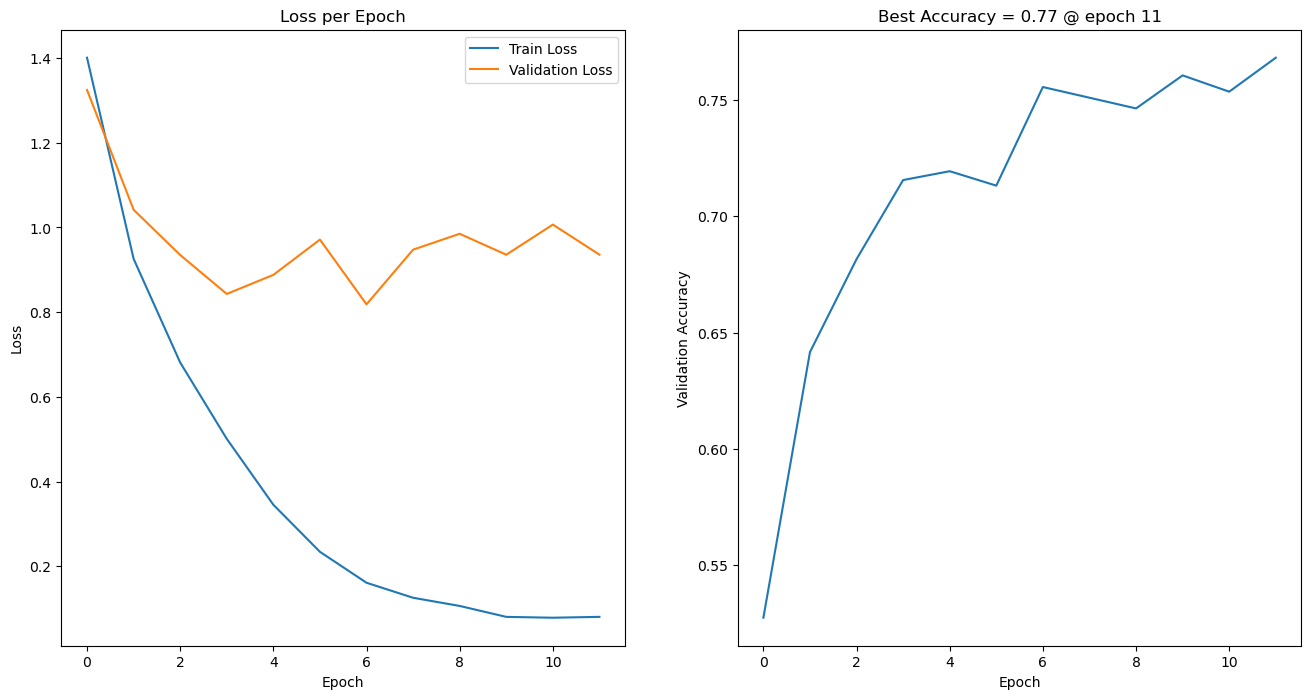

In [ ]:
# RESNET NO SKIP
convnet = ResNet([2, 2, 2, 2], 10, 3, skip_connection=False)
optimizer_convnet = torch.optim.Adam(params=convnet.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

epochs = 50
batch_size = 128
lr = 0.0001

model_name = 'convnet_cifar.pth'
fig_path = 'results/convnet_cifar.png'

# Train and test the models
train(convnet, train_set, criterion, optimizer_convnet, batch_size, epochs, model_name, fig_path, device=device)


epoch,▁▂▃▄▅▅▆▇█
train_loss,█▅▄▃▂▂▁▁▁
val_accuracy,▁▅▆▇▆▇▇██
val_loss,█▄▂▁▅▃▅▃▄
epoch,8
train_loss,0.05168
val_accuracy,0.7996
val_loss,0.86627


Training-Set Ready
Validation-Set Ready
Starting Training...


Training epoch 10: 100%|██████████| 352/352 [00:27<00:00, 12.98it/s]


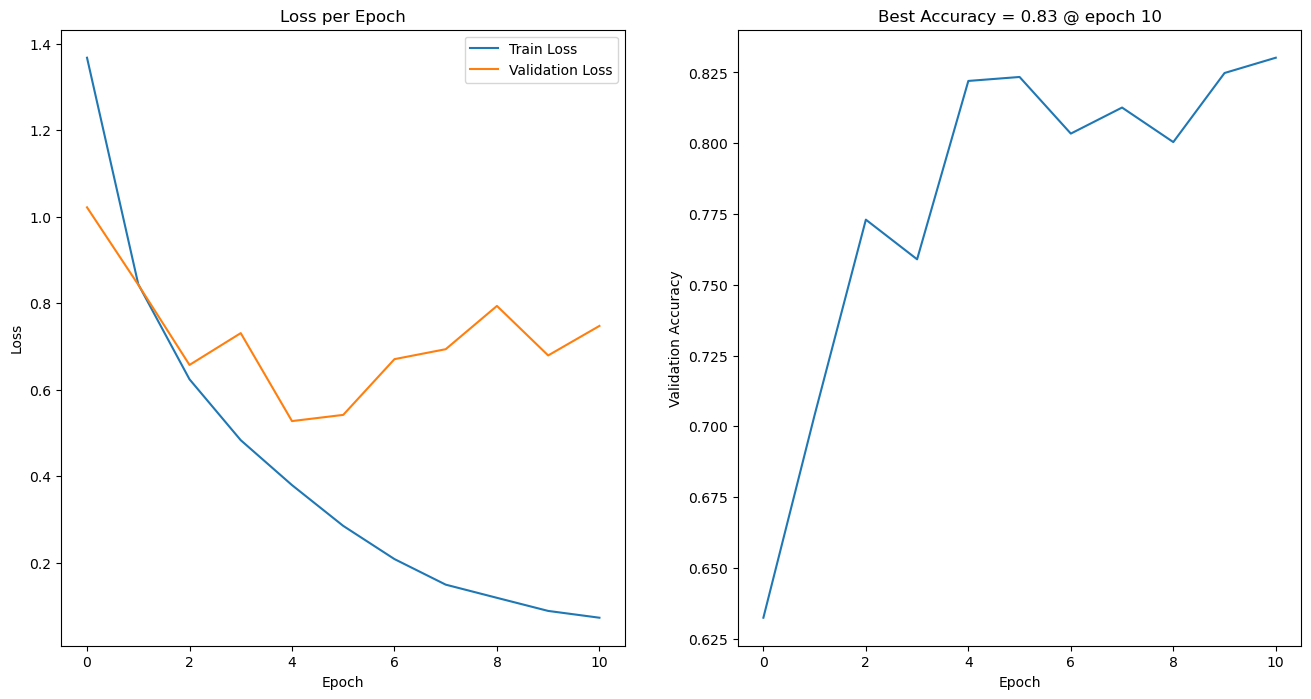

In [ ]:
# RESNET
resnet = ResNet([2, 2, 2, 2], 10, 3, skip_connection=True)
optimizer_resnet = torch.optim.Adam(params=resnet.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

epochs = 50
batch_size = 128
lr = 0.0001

model_name = 'resnet_cifar.pth'
fig_path = 'results/resnet_cifar.png'

# Train and test the models
train(resnet, train_set, criterion, optimizer_resnet, batch_size, epochs, model_name, fig_path, num_workers=num_workers, device=device)


In [ ]:
mlp = MLP(32, 3, 10)
small_cnn = CNN()
convnet = ResNet([2, 2, 2, 2], 10, 3, skip_connection=False)
resnet = ResNet([2, 2, 2, 2], 10, 3, skip_connection=True)

test(mlp, test_set, criterion, 'mlp_cifar.pth', device=device)
test(cnn, test_set, criterion, 'cnn_cifar.pth', device=device)
test(convnet, test_set, criterion, 'convnet_cifar.pth', device=device)
test(resnet, test_set, criterion, 'resnet_cifar.pth', device=device)

/tmp/ipykernel_1350118/3237450817.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join('./trained_models/', model_name)))


Loading model...
Model Loaded


/tmp/ipykernel_1350118/3237450817.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join('./trained_models/', model_name)))


Test Accuracy: 0.4302
              precision    recall  f1-score   support

           0      0.292     0.642     0.401      1000
           1      0.673     0.600     0.635      1000
           2      0.394     0.555     0.461      1000
           3      0.267     0.649     0.379      1000
           4      0.000     0.000     0.000      1000
           5      0.000     0.000     0.000      1000
           6      0.592     0.583     0.588      1000
           7      0.000     0.000     0.000      1000
           8      0.652     0.666     0.659      1000
           9      0.569     0.607     0.588      1000

    accuracy                          0.430     10000
   macro avg      0.344     0.430     0.371     10000
weighted avg      0.344     0.430     0.371     10000

Loading model...
Model Loaded


/tmp/ipykernel_1350118/3237450817.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join('./trained_models/', model_name)))


Test Accuracy: 0.7028
              precision    recall  f1-score   support

           0      0.774     0.714     0.743      1000
           1      0.805     0.819     0.812      1000
           2      0.666     0.547     0.601      1000
           3      0.522     0.537     0.529      1000
           4      0.620     0.694     0.655      1000
           5      0.576     0.625     0.600      1000
           6      0.867     0.660     0.750      1000
           7      0.735     0.786     0.760      1000
           8      0.748     0.856     0.798      1000
           9      0.766     0.790     0.778      1000

    accuracy                          0.703     10000
   macro avg      0.708     0.703     0.702     10000
weighted avg      0.708     0.703     0.702     10000

Loading model...
Model Loaded


/tmp/ipykernel_1350118/3237450817.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join('./trained_models/', model_name)))


Test Accuracy: 0.7537
              precision    recall  f1-score   support

           0      0.780     0.773     0.776      1000
           1      0.909     0.872     0.890      1000
           2      0.701     0.631     0.664      1000
           3      0.512     0.674     0.582      1000
           4      0.764     0.677     0.718      1000
           5      0.750     0.529     0.621      1000
           6      0.803     0.817     0.810      1000
           7      0.723     0.847     0.780      1000
           8      0.886     0.821     0.852      1000
           9      0.795     0.896     0.843      1000

    accuracy                          0.754     10000
   macro avg      0.762     0.754     0.754     10000
weighted avg      0.762     0.754     0.754     10000

Loading model...
Model Loaded


Test Accuracy: 0.8221
              precision    recall  f1-score   support

           0      0.763     0.906     0.828      1000
           1      0.881     0.949     0.914      1000
           2      0.735     0.789     0.761      1000
           3      0.763     0.569     0.652      1000
           4      0.847     0.745     0.793      1000
           5      0.701     0.798     0.746      1000
           6      0.913     0.809     0.858      1000
           7      0.820     0.891     0.854      1000
           8      0.918     0.870     0.893      1000
           9      0.916     0.895     0.905      1000

    accuracy                          0.822     10000
   macro avg      0.826     0.822     0.820     10000
weighted avg      0.826     0.822     0.820     10000



-----
## Exercise 2: Choose at Least One

Below are **three** exercises that ask you to deepen your understanding of Deep Networks for visual recognition. You must choose **at least one** of the below for your final submission -- feel free to do **more**, but at least **ONE** you must submit.

### Exercise 2.1: Explain why Residual Connections are so effective
Use your two models (with and without residual connections) you developed above to study and **quantify** why the residual versions of the networks learn more effectively.

**Hint**: A good starting point might be looking at the gradient magnitudes passing through the networks during backpropagation.

In [ ]:
# Your code here.

### Exercise 2.2: Fully-convolutionalize a network.
Take one of your trained classifiers and **fully-convolutionalize** it. That is, turn it into a network that can predict classification outputs at *all* pixels in an input image. Can you turn this into a **detector** of handwritten digits? Give it a try.

**Hint 1**: Sometimes the process of fully-convolutionalization is called "network surgery".

**Hint 2**: To test your fully-convolutionalized networks you might want to write some functions to take random MNIST samples and embed them into a larger image (i.e. in a regular grid or at random positions).

In [ ]:
# Standard MNIST transform.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST train and test.
train_set = MNIST(root='./data', train=True, download=True, transform=transform)
test_set = MNIST(root='./data', train=False, download=True, transform=transform)

### Architecture

In [ ]:
class CNN(nn.Module):
    def __init__(self, input_channels, hidden_dim=32, output_dim = 10):  # 28x28
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, hidden_dim, kernel_size=3, stride = 2, padding=1)  # 14x14x32
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim * 2, kernel_size=3, stride = 2, padding=1)  # 7x7x64
        self.conv3 = nn.Conv2d(hidden_dim * 2, hidden_dim * 4, kernel_size=3, stride = 1, padding=1)  # 7x7x128
        self.conv4 = nn.Conv2d(hidden_dim * 4, hidden_dim * 8, kernel_size=3, stride = 1, padding=1)  # 7x7x256
        self.classifier = nn.Sequential(
            nn.Linear(12544, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        return self.classifier(x.flatten(1))

In [ ]:
epochs = 25
batch_size = 128
lr = 0.0001
criterion = nn.CrossEntropyLoss()

model_name = 'cnn_mnist.pth'
fig_path = 'results/cnn_mnist.png'

cnn = CNN(1)
optimizer_cnn = torch.optim.Adam(params=cnn.parameters(), lr=lr)

train(cnn, train_set, criterion, optimizer_cnn, batch_size, epochs, model_name, fig_path, num_workers=8, device=device)

In [ ]:
class FCN(nn.Module):

    def __init__(self, pretrained_net, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.pretrained_net = nn.Sequential(*list(pretrained_net.children())[:-1])  # 7x7x256
        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)  # 14x14x128
        self.bn1     = nn.BatchNorm2d(128)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)  # 28x28x64
        self.bn2     = nn.BatchNorm2d(64)
        self.classifier = nn.Conv2d(64, num_classes, kernel_size=1)  # 28x28x10

    def forward(self, x):
        output = self.pretrained_net(x)
        score = self.bn1(self.relu(self.deconv1(output)))
        score = self.bn2(self.relu(self.deconv2(score)))
        score = self.classifier(score)
        return score

### Custom MNIST Dataset
Create a new custom dataset of handwritten digits with images of size 64x64

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import numpy as np

class CustomMNIST(Dataset):
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False, image_size=64):
        super().__init__()
        self.dataset = MNIST(root, train, transform, target_transform, download)
        self.transform = transform
        self.image_size = image_size

    def __getitem__(self, index):
        img, target = self.dataset[index]
        #make a new image and place the original image somewhere in the new image
        new_img = Image.new('1', (self.image_size, self.image_size), 0)
        convert_to_pil = transforms.ToPILImage()
        new_img = self.transform(new_img)
        #sum the two tensors but img is shifted by 16 pixels
        #pick two random numbers between 0 and 32
        x = np.random.randint(0, self.image_size - 28)
        y = np.random.randint(0, self.image_size - 28)
        #sum two tensors of different shape
        new_img[:,x:x+28, y:y+28] = img
        return new_img, target

    def __len__(self):
        return len(self.dataset)

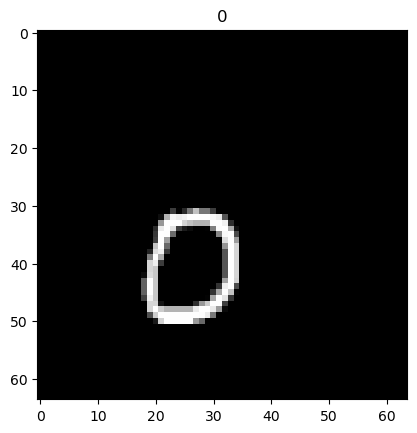

In [ ]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

cust_mnist = CustomMNIST(root='./data', train=False, download=True, transform=transform, image_size=64)
# Show an example image
img, target, _, _ = cust_mnist[10]
img = img.permute(1,2,0)
plt.imshow(img, cmap='gray')
plt.title(target)
plt.show()


### Train the FCN Model

In [ ]:
cnn = CNN(1)
cnn.load_state_dict(torch.load('trained_models/cnn_mnist.pth'))
test(cnn, test_set, criterion, 'cnn_mnist.pth', device=device)

/tmp/ipykernel_1626180/1445941353.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn.load_state_dict(torch.load('trained_models/cnn_mnist.pth'))
/tmp/ipykernel_1626180/

Loading model...
Model Loaded


Test Accuracy: 0.9884
              precision    recall  f1-score   support

           0      0.989     0.993     0.991       980
           1      0.996     0.993     0.995      1135
           2      0.984     0.991     0.987      1032
           3      0.995     0.984     0.990      1010
           4      0.994     0.986     0.990       982
           5      0.984     0.990     0.987       892
           6      0.988     0.992     0.990       958
           7      0.985     0.990     0.988      1028
           8      0.979     0.986     0.982       974
           9      0.989     0.979     0.984      1009

    accuracy                          0.988     10000
   macro avg      0.988     0.988     0.988     10000
weighted avg      0.988     0.988     0.988     10000



In [ ]:
# Training hyperparameters.
epochs = 25
batch_size = 64
lr = 0.0001
criterion = nn.CrossEntropyLoss()

fcn_model = FCN(cnn, 10)
optimizer = torch.optim.Adam(params=fcn_model.parameters(), lr=lr)

model_name = 'fcn_mnist.pth'
fig_path = 'results/fcn_mnist.png'
print(fcn_model)

FCN(
  (pretrained_net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (relu): ReLU(inplace=True)
  (deconv1): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (classifier): Conv2d(64, 10, kernel_size=(1, 1), stride=(1, 1))
)


Training-Set Ready
Validation-Set Ready
Starting Training...


Training epoch 24: 100%|██████████| 843/843 [00:11<00:00, 76.32it/s]


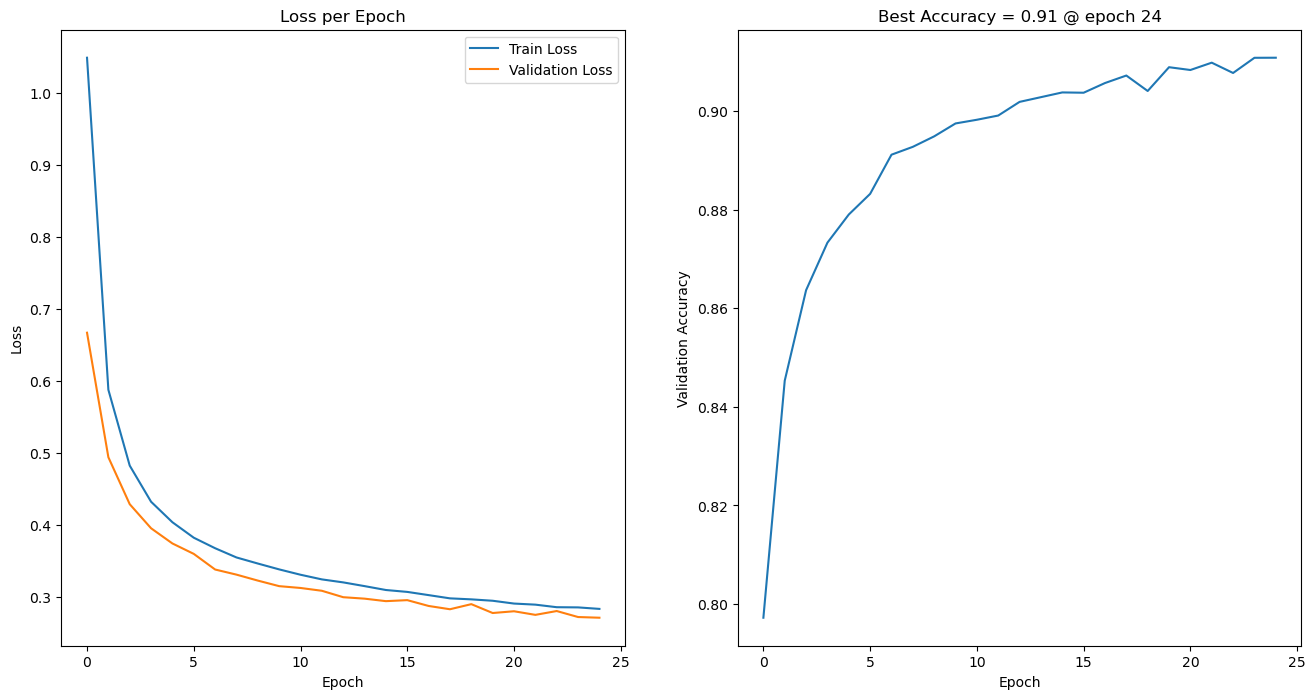

In [ ]:
trainset = CustomMNIST(root='./data', train=True, download=True, transform=transform)
train(fcn_model, train_set, criterion, optimizer, batch_size, epochs, model_name, fig_path, num_workers=8, device=device, fully_conv=True)

In [ ]:
test(fcn_model, test_set, criterion, 'fcn_mnist.pth', device=device, fully_conv=True)

/tmp/ipykernel_1626180/2819179214.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join('./trained_models/', model_name)))


Loading model...
Model Loaded


Test Accuracy: 0.9148802295918367
              precision    recall  f1-score   support

           0      0.929     0.961     0.944    768320
           1      0.971     0.981     0.976    889840
           2      0.914     0.919     0.916    809088
           3      0.865     0.888     0.876    791840
           4      0.922     0.916     0.919    769888
           5      0.884     0.852     0.867    699328
           6      0.925     0.941     0.933    751072
           7      0.928     0.924     0.926    805952
           8      0.910     0.882     0.896    763616
           9      0.891     0.871     0.881    791056

    accuracy                          0.915   7840000
   macro avg      0.914     0.913     0.913   7840000
weighted avg      0.915     0.915     0.915   7840000



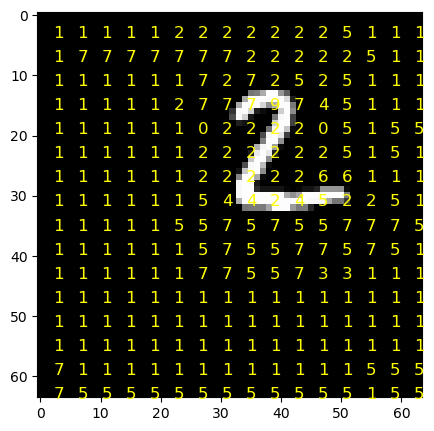

In [ ]:
# Show predictions of the FCN Model
img, _, _, _= cust_mnist[1]
img = img.unsqueeze(0).to(device)
output = fcn_model(img)
pred = torch.argmax(output, 1).squeeze()

plt.figure(figsize=(5,5))
plt.imshow(img.cpu().squeeze().numpy(), cmap = 'gray')
for i in range(3, pred.shape[0], 4):
    for j in range(3, pred.shape[1], 4):
        plt.text(j, i, str(pred[i,j].item()),ha='center', va='center', color = 'yellow', fontsize = 12)
plt.show()

### Exercise 2.3: *Explain* the predictions of a CNN

Use the CNN model you trained in Exercise 1.2 and implement [*Class Activation Maps*](http://cnnlocalization.csail.mit.edu/#:~:text=A%20class%20activation%20map%20for,decision%20made%20by%20the%20CNN.):

> B. Zhou, A. Khosla, A. Lapedriza, A. Oliva, and A. Torralba. Learning Deep Features for Discriminative Localization. CVPR'16 (arXiv:1512.04150, 2015).

Use your implementation to demonstrate how your trained CNN *attends* to specific image features to recognize *specific* classes.

**Note**: Feel free to implement [Grad-CAM](https://arxiv.org/abs/1610.02391) instead of CAM.

In [21]:
# Standard CIFAR10 transform.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

# Load CIFAR10 train and test.
train_set = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = CIFAR10(root='./data', train=False, download=True, transform=transform)

num_classes = 10
input_channels = 3

Files already downloaded and verified
Files already downloaded and verified


In [34]:
import cv2

class GradCAM:
    def __init__(self, model, target_layer, input_size):
        self.model = model
        self.target_layer = target_layer
        self.gradients = dict()
        self.activations = dict()
        self.input_size = input_size

        def forward_hook(module, input, output):
            self.activations['value'] = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients['value'] = grad_out[0]

        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

    def forward(self, input, class_idx=None):
        self.model.eval()
        output = self.model(input)

        if class_idx is None:
            class_idx = torch.argmax(output)

        score = output[:, class_idx].squeeze()
        self.model.zero_grad()
        score.backward()

        gradients = self.gradients['value']
        activations = self.activations['value']

        b, k, u, v = gradients.size()
        alpha = gradients.view(b, k, -1).mean(2)
        weights = alpha.view(b, k, 1, 1)

        grad_cam_map = (weights * activations).sum(1, keepdim=True)
        grad_cam_map = F.relu(grad_cam_map)
        grad_cam_map = F.interpolate(grad_cam_map, size=self.input_size, mode='bilinear', align_corners=False)
        grad_cam_map_min, grad_cam_map_max = grad_cam_map.min(), grad_cam_map.max()
        grad_cam_map = (grad_cam_map - grad_cam_map_min).div(grad_cam_map_max - grad_cam_map_min).data

        return grad_cam_map, output

    def __call__(self, input, class_idx=None):
        return self.forward(input, class_idx)

In [35]:
def visualize_cam(mask, img):
    """Make heatmap from mask and synthesize GradCAM result image using heatmap and img.
    Args:
        mask (torch.tensor): mask shape of (1, 1, H, W) and each element has value in range [0, 1]
        img (torch.tensor): img shape of (1, 3, H, W) and each pixel value is in range [0, 1]

    Return:
        heatmap (torch.tensor): heatmap img shape of (3, H, W)
        result (torch.tensor): synthesized GradCAM result of same shape with heatmap.
    """
    heatmap = cv2.applyColorMap(np.uint8(255 * mask.squeeze()), cv2.COLORMAP_JET)
    heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float().div(255)
    b, g, r = heatmap.split(1)
    heatmap = torch.cat([r, g, b])

    result = heatmap + img.cpu()
    result = result.div(result.max()).squeeze()

    return heatmap, result

In [36]:
class NormalizeInverse(transforms.Normalize):
    """
    Undoes the normalization and returns the reconstructed images in the input domain.
    """

    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())

In [65]:
model = ResNet([2, 2, 2, 2], 10, 3, skip_connection=False)
model.load_state_dict(torch.load('trained_models/convnet_cifar.pth', map_location=device))

gradcam = GradCAM(model, target_layer=model.layers[3][1].block[4], input_size=(32, 32))

inv = NormalizeInverse((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

<ipython-input-65-e89e69428ffc>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('trained_models/convnet_cifar.pth', map_location=device))


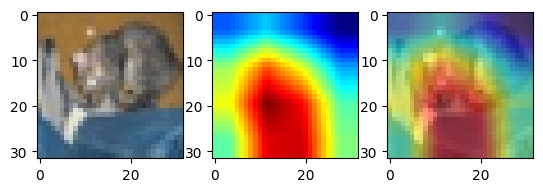

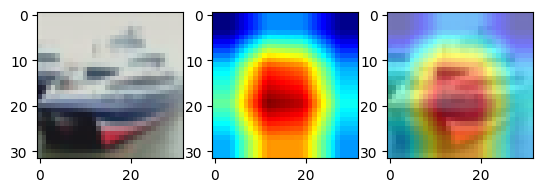

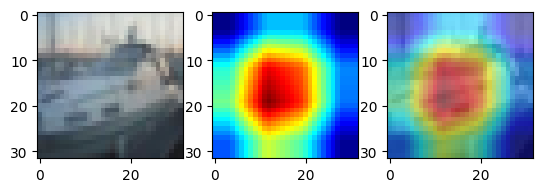

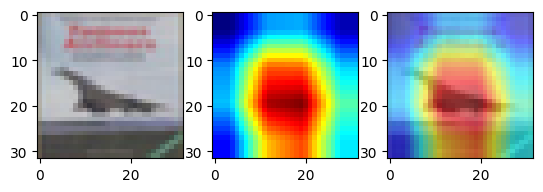

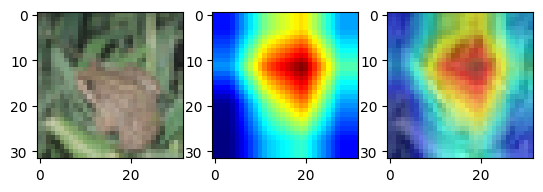

In [67]:
for i in range(5):
    img, _ = test_set[i]
    img = img.unsqueeze(0)
    img = inv(img)

    mask, output = gradcam(img.to(device))
    heatmap, result = visualize_cam(mask, img)

    _, axarr = plt.subplots(1,3)
    axarr[0].imshow(np.transpose(img.squeeze().numpy(), (1, 2, 0)))
    axarr[1].imshow(np.transpose(heatmap, (1, 2, 0)))
    axarr[2].imshow(np.transpose(result, (1, 2, 0)))
    plt.show()